In [151]:
import numpy as np
import pandas as pd
import open3d
import os
import tqdm
import matplotlib.pyplot as plt
import utils.helpers as helpers
import utils.fread as fread
import utils.registration as registration
import copy

from utils.depth_camera import DepthCamera
from utils.config import Config

import utils.registration as registration
import utils.fread as fread
import utils.FCGF as FCGF
import utils.helpers as helpers

from scipy import signal
from scipy.ndimage import gaussian_filter1d
from scipy import interpolate
from PIL import Image

from scipy.signal import argrelmin, argrelmax, find_peaks

In [164]:
config = Config(
    sequence_dir="data/raw_data",
    feature_dir="data/features",
    output_dir="data/trajectories/estimated_imu+depth",
    experiment="exp_8",
    trial="trial_3",
    subject="subject-1",
    sequence="02",
    groundtruth_dir="data/trajectories/groundtruth",
    voxel_size=0.03
)

In [165]:
pose_file = os.path.join(config.get_groundtruth_dir(), f"{config.get_file_name()}.pose.npz")
motion_dir = config.get_motion_dir(include_secondary=False)

accel_df = pd.read_csv(os.path.join(motion_dir, "accel.csv"))
gyro_df = pd.read_csv(os.path.join(motion_dir, "gyro.csv"))

accel_df.drop_duplicates("timestamp", inplace=True)
gyro_df.drop_duplicates("timestamp", inplace=True)
imu_df = pd.merge(accel_df, gyro_df, on="timestamp", suffixes=("a", "g"))

frame_rate = accel_df.shape[0] / (accel_df.timestamp.values[-1] - accel_df.timestamp.values[0]) * 1000
win_len = int(frame_rate * 4) # 4 seconds window

# compute dt in seconds
imu_df.loc[:, "dt"] = np.concatenate([[0], (imu_df.timestamp.values[1:] - imu_df.timestamp.values[:-1]) / 1000])
# remove first row as the dt is 0
imu_df = imu_df.iloc[1:]
# reset index in pandas data frame
imu_df.reset_index(drop=True, inplace=True)

# Fill 0 for displacement, angles, and coordinates
imu_df.loc[:, "x"] = np.zeros(len(imu_df))
imu_df.loc[:, "y"] = np.zeros(len(imu_df))
imu_df.loc[:, "z"] = np.zeros(len(imu_df))

In [166]:
sigma = 2
# apply gaussian filter to smooth acceleration and gyro data
imu_df.loc[:, "xa"] = gaussian_filter1d(imu_df.xa.values, sigma=sigma)
imu_df.loc[:, "ya"] = gaussian_filter1d(imu_df.ya.values, sigma=sigma)
imu_df.loc[:, "za"] = gaussian_filter1d(imu_df.za.values, sigma=sigma)
imu_df.loc[:, "xg"] = gaussian_filter1d(imu_df.xg.values, sigma=sigma)
imu_df.loc[:, "yg"] = gaussian_filter1d(imu_df.yg.values, sigma=sigma)
imu_df.loc[:, "zg"] = gaussian_filter1d(imu_df.zg.values, sigma=sigma)

In [167]:
gravity = imu_df.iloc[:win_len, [1, 2, 3]].mean().values

imu_df[["xa", "ya", "za"]] = imu_df[["xa", "ya", "za"]] - gravity
    
accel_mavg = imu_df[["xa", "ya", "za"]].rolling(window=win_len).mean()
accel_mavg.fillna(0, inplace=True)
imu_df[["xa", "ya", "za"]] = imu_df[["xa", "ya", "za"]] - accel_mavg

imu_df = imu_df.iloc[win_len:].copy()

<AxesSubplot:title={'center':'displacement'}, xlabel='timestamp'>

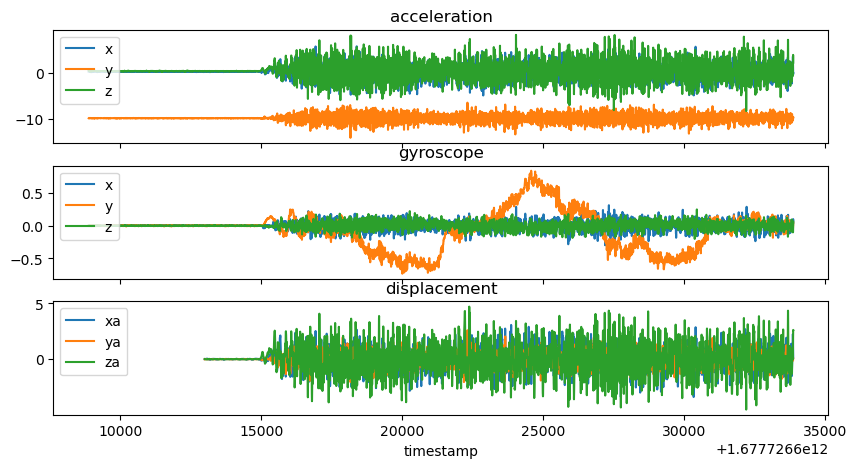

In [168]:
fig, axs = plt.subplots(3, 1, figsize=(10, 5), sharex=True)

accel_df.plot(x="timestamp", y=["x", "y", "z"], ax=axs[0], title="acceleration")
gyro_df.plot(x="timestamp", y=["x", "y", "z"], ax=axs[1], title="gyroscope")
imu_df.plot(x="timestamp", y=["xa", "ya", "za"], ax=axs[2], title="displacement")

In [169]:
# load ground truth trajectory
sequence_ts = fread.get_timstamps_from_images(config.get_sequence_dir(include_secondary=False), ext=".depth.png")
start_t = helpers.nearest(sequence_ts, imu_df.timestamp.values[0])
start_index = np.where(sequence_ts == start_t)[0][0]

poses = np.load(pose_file)
trajectory_t = poses["trajectory_t"]

In [170]:
depth_camera = DepthCamera("secondary", os.path.join(config.sequence_dir, config.experiment, "metadata", "device-0-aligned.json"))

local_pcds = []

for t in tqdm.trange(len(sequence_ts)):
    depth_img_file = os.path.join(config.get_sequence_dir(include_secondary=False), f"frame-{sequence_ts[t]}.depth.png")
    pcd = depth_camera.depth_to_point_cloud(depth_img_file)
    pcd = pcd.voxel_down_sample(voxel_size=config.voxel_size)
    local_pcds.append(pcd)

100%|██████████| 551/551 [00:18<00:00, 29.86it/s]


In [171]:
mean_values = []
std_values = []

for t in range(len(sequence_ts)):
    depth_img_file = os.path.join(config.get_sequence_dir(include_secondary=False), f"frame-{sequence_ts[t]}.depth.png")
    depth_img = Image.open(depth_img_file).convert("I")
    depth_img = np.array(depth_img) / 4000
    std_values.append(np.std(depth_img))
    
std_values = np.array(std_values)

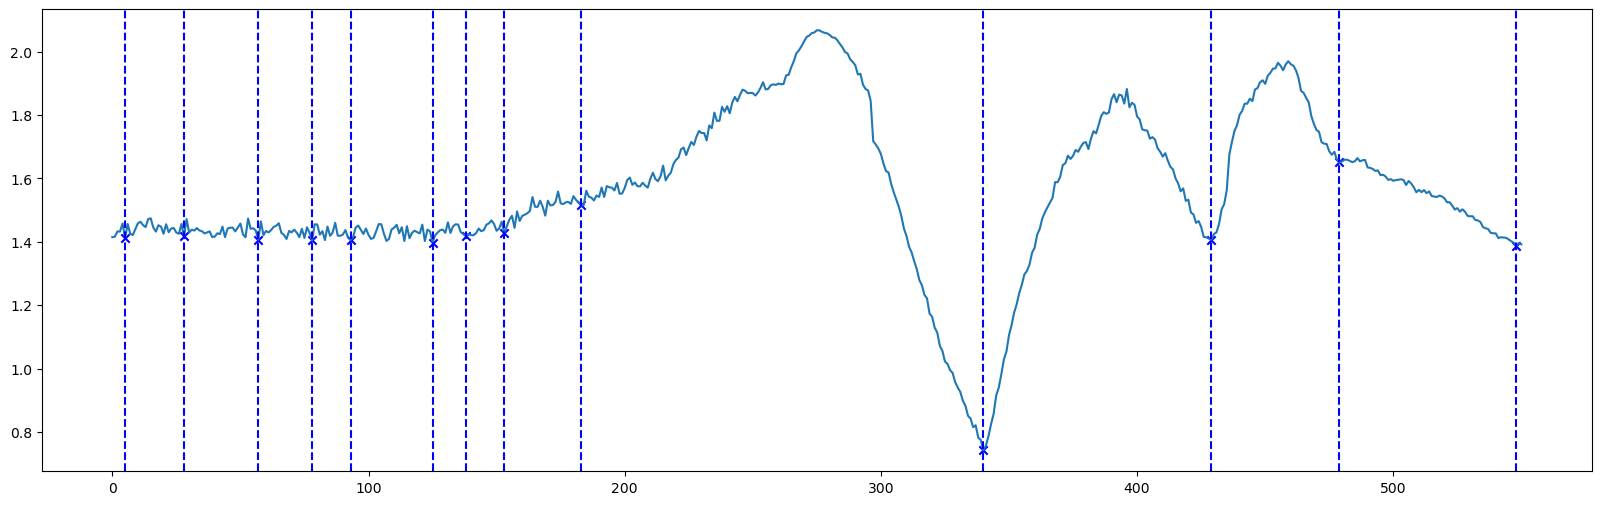

In [172]:
plt.figure(figsize=(20, 6))
plt.plot(std_values)

min_indices = argrelmin(std_values, order=10)[0]    

plt.scatter(min_indices, std_values[min_indices], c="b", marker="x")
    
for x in min_indices:
    plt.axvline(x, c="b", linestyle="--")

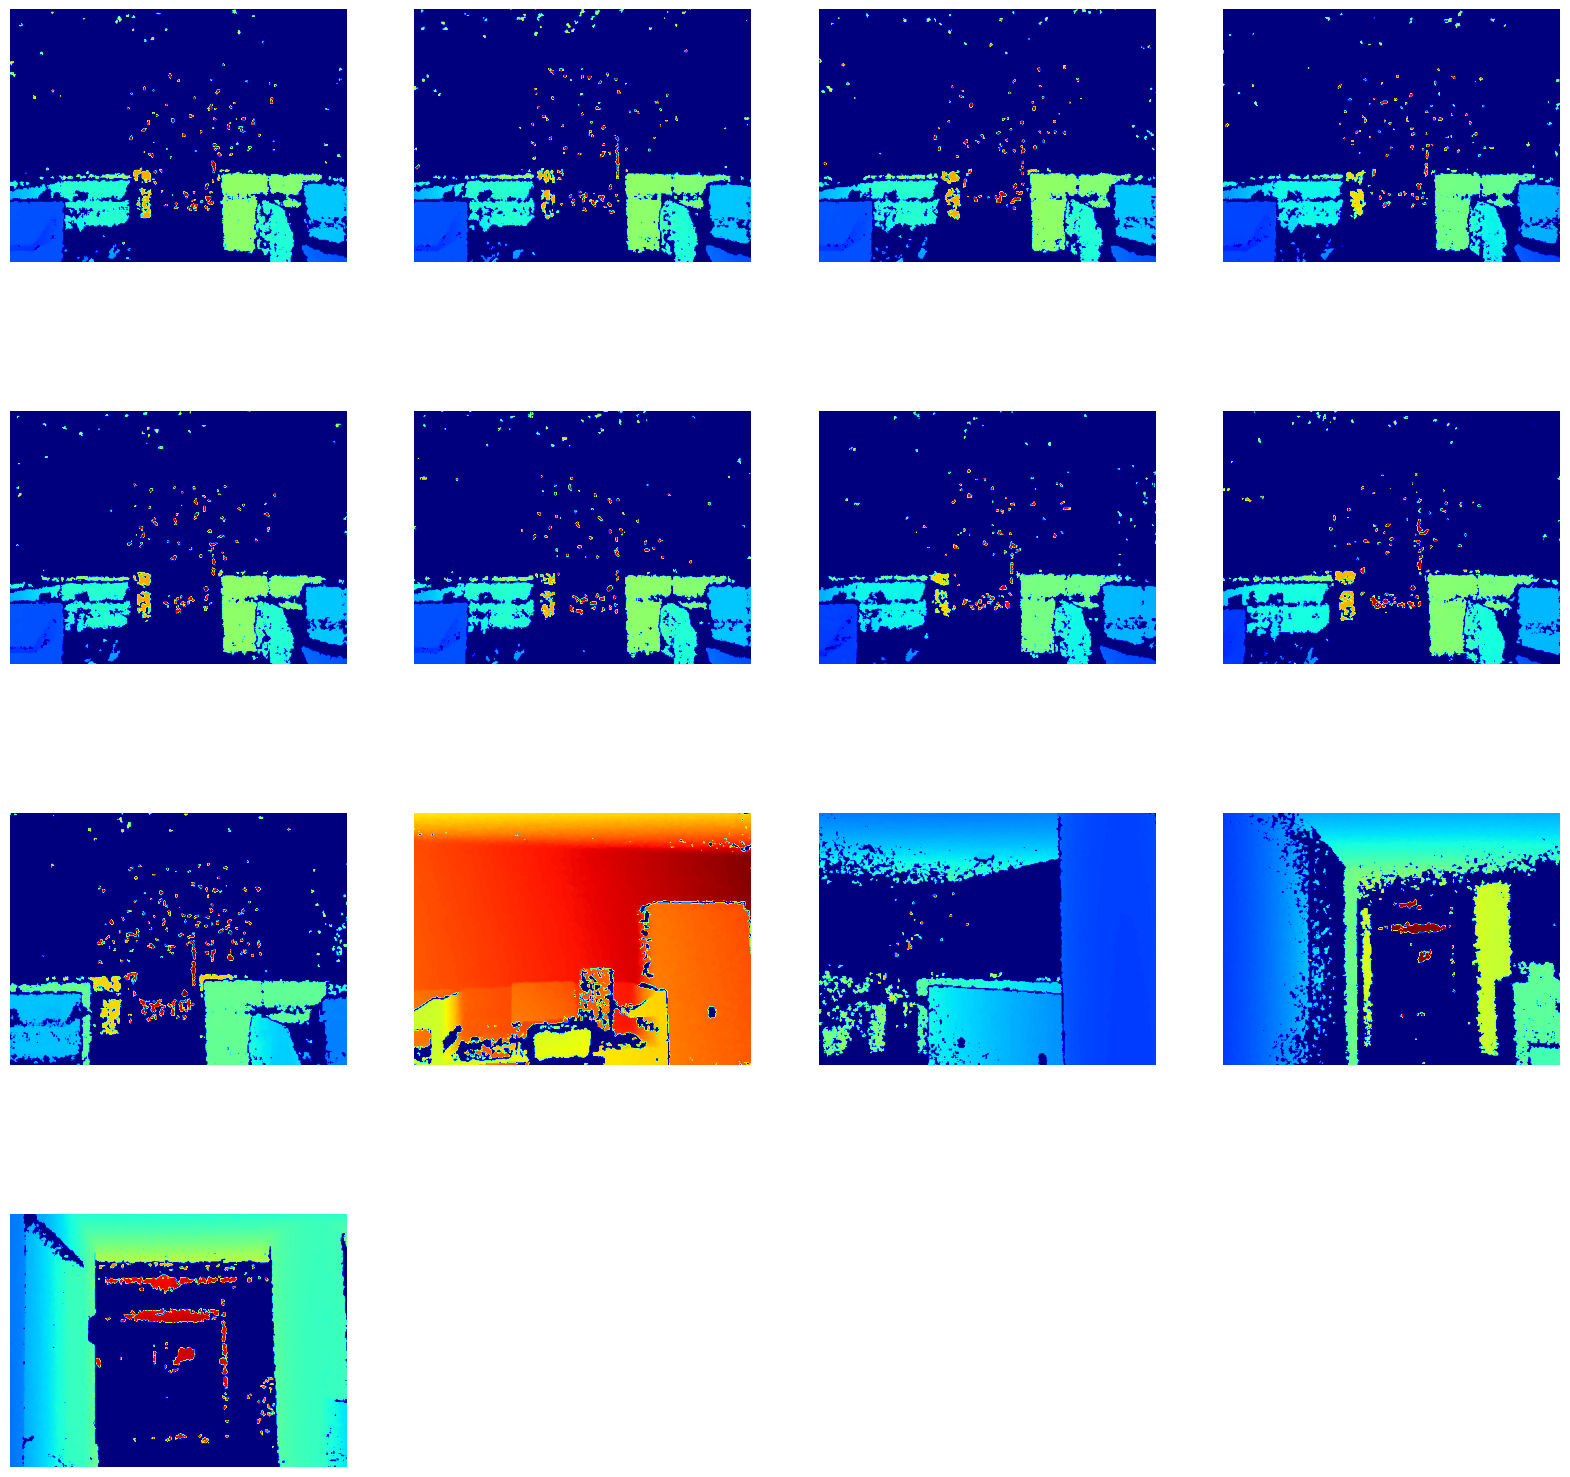

In [173]:
plt.figure(figsize=(20, 20))
for i in range(4):
    for j in range(4):
        if 4 * i + j > len(min_indices) - 1:
            break
        
        img = Image.open(os.path.join(config.get_sequence_dir(include_secondary=False), f"frame-{sequence_ts[min_indices[4 * i + j]]}.depth.png")).convert("I")
        plt.subplot(4, 4, (4 * i) + j + 1)
        plt.imshow(np.asarray(img), cmap="jet")
        plt.axis("off")

In [174]:
start_t, end_t = start_index, start_index + 1

gt_transform = np.dot(helpers.inv_transform(trajectory_t[start_t]), trajectory_t[end_t])
velocity = gt_transform[:3, 3] * 1e3 / (sequence_ts[end_t] - sequence_ts[start_t])

local_t = [np.identity(4), gt_transform]

In [175]:
for t in tqdm.trange(start_index + 1, len(sequence_ts) - 1):
    start_t, end_t = t, t + 1
    
    imu_slice_df = imu_df[(imu_df.timestamp >= sequence_ts[start_t]) & (imu_df.timestamp <= sequence_ts[end_t])]
    
    # calculate displacement and rotation
    rotation_matrix = np.identity(4)
    translation = np.zeros(3)

    for i in range(len(imu_slice_df)):
        v = imu_slice_df.iloc[i].values
        
        dt = v[7]
        
        # current displacement and rotation
        da = np.degrees([v[j + 4] * dt for j in range(3)])
        
        acceleration = imu_slice_df.iloc[i, [1, 2, 3]].values

        d = [(velocity[j] * dt) + (0.5 * acceleration[j] * dt * dt) for j in range(3)]
        d = np.dot(rotation_matrix, np.array([*d, 1]))
        
        translation = translation + d[:3]
        velocity = [velocity[j] + acceleration[j] * dt for j in range(3)]
        
        rotation_matrix = helpers.rotate_transformation_matrix(rotation_matrix, da[0], da[1], da[2])
        
    # translation = 0.2 * previous_translation + 0.8 * translation
    # translation = 0.2 * local_t[-1][:3, 3] + 0.8 * translation
    
    trans_mat = np.identity(4)
    trans_mat[:3, 3] = translation
    trans_mat[:3, :3] = rotation_matrix[:3, :3]
    
    source = copy.deepcopy(local_pcds[end_t])
    target = copy.deepcopy(local_pcds[start_t])
    
    refined_transform = registration.icp_refinement(source, target, 0.05, trans_init=trans_mat, max_iteration=30, p2p=True).transformation
    
    velocity = refined_transform[:3, 3] * 1e3 / (sequence_ts[end_t] - sequence_ts[start_t])
    
    local_t.append(refined_transform)

100%|██████████| 480/480 [00:26<00:00, 18.45it/s]


In [176]:
local_t = np.array(local_t)
    
trajectory_estimated_t = [np.identity(4)]

for t in range(1, len(local_t)):
    trajectory_estimated_t.append(np.dot(trajectory_estimated_t[t - 1], local_t[t]))
    
trajectory_estimated_t = np.array(trajectory_estimated_t)

trajectory_pcd = []

for t in range(start_index, len(sequence_ts)):
    pcd = copy.deepcopy(local_pcds[t])
    pcd.transform(trajectory_estimated_t[t - start_index])
    trajectory_pcd.append(pcd)
    
trajectory_pcd = helpers.merge_pcds(trajectory_pcd, config.voxel_size)

In [177]:
# open3d.visualization.draw_geometries([trajectory_pcd])

In [178]:
estimated_pcd = helpers.make_pcd(trajectory_estimated_t[:, :3, 3])
groundtruth_pcd = helpers.make_pcd(trajectory_t[start_index:, :3, 3])

avg_distance_error = np.mean(np.linalg.norm(trajectory_estimated_t[:, :3, 3] - trajectory_t[start_index:, :3, 3], axis=1))
print(f"RMSE: {avg_distance_error:.3f} m")

RMSE: 0.690 m


In [179]:
# registration.view(estimated_pcd, groundtruth_pcd, np.identity(4))

In [180]:
fpfh_feats = []

for i in tqdm.trange(len(local_pcds)):
    pcd = local_pcds[i]
    fpfh = registration.compute_fpfh(pcd, config.voxel_size)
    fpfh_feats.append(fpfh)

100%|██████████| 551/551 [01:56<00:00,  4.74it/s]


In [181]:
fpfh_local_t = [np.identity(4)]

for t in tqdm.trange(len(local_pcds) - 1):
    ransac_reg = registration.ransac_feature_matching(local_pcds[t + 1], local_pcds[t], fpfh_feats[t + 1], fpfh_feats[t], n_ransac=4, threshold=0.05)
    icp_reg = registration.icp_refinement(local_pcds[t + 1], local_pcds[t], trans_init=ransac_reg.transformation, max_iteration=200, threshold=0.05, p2p=False)
    fpfh_local_t.append(icp_reg.transformation)

100%|██████████| 550/550 [06:14<00:00,  1.47it/s]


In [182]:
fpfh_local_t = np.array(fpfh_local_t)

fpfh_trajectory_t = [np.identity(4)]

for t in tqdm.trange(1, len(local_pcds)):
    fpfh_trajectory_t.append(np.dot(fpfh_trajectory_t[t - 1], fpfh_local_t[t]))
    local_pcds[t].transform(fpfh_trajectory_t[t])
    
fpfh_trajectory_t = np.array(fpfh_trajectory_t)

estimated_fpfh_pcd = helpers.make_pcd(fpfh_trajectory_t[:, :3, 3])

100%|██████████| 550/550 [00:00<00:00, 6842.62it/s]


In [183]:
avg_distance_error = np.mean(np.linalg.norm(fpfh_trajectory_t[:, :3, 3] - trajectory_t[:, :3, 3], axis=1))
print(f"RMSE: {avg_distance_error:.3f} m")

RMSE: 4.548 m


In [184]:
registration.view(estimated_fpfh_pcd, groundtruth_pcd, np.identity(4))
registration.view(estimated_pcd, groundtruth_pcd, np.identity(4))

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 


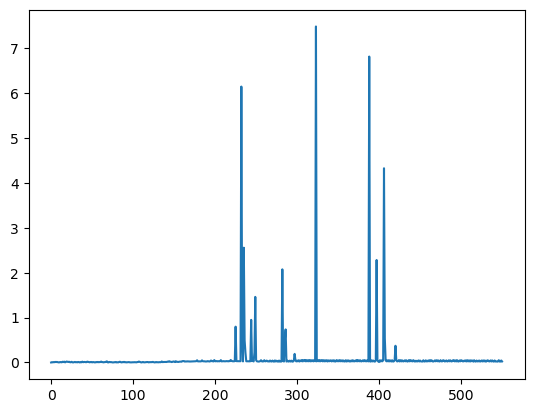

In [185]:
fpfh_distances = np.linalg.norm(fpfh_local_t[:, :3, 3], axis=1)

plt.plot(fpfh_distances)

In [186]:
indices = np.where(fpfh_distances > 0.5)[0]

In [187]:
for t in indices:
    registration.view(local_pcds[t + 1], local_pcds[t], fpfh_local_t[t])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transfor